In [31]:
import torch
from torchvision import datasets, transforms
from utility.HebbianNetworkClassifier import HebbianNetworkClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

# set seed for reproducibility
torch.manual_seed(42)

In [32]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Download and load the MNIST training dataset
trn_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=64, shuffle=True)

# Split the training dataset into training and validation datasets
train_size = int(0.85 * len(trn_dataset))
val_size = len(trn_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trn_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=True)


# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)


In [33]:
# Print the number of samples in the training and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 51000
Number of test samples: 10000


In [34]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_size = [784, 512, 256, 10]
model = HebbianNetworkClassifier(model_size, device=device, init="uni", dropout=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

print("Number of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Number of weights: ", sum(model_size[i] * model_size[i + 1] for i in range(len(model_size) - 1)))


Number of parameters:  7016
Number of weights:  535040


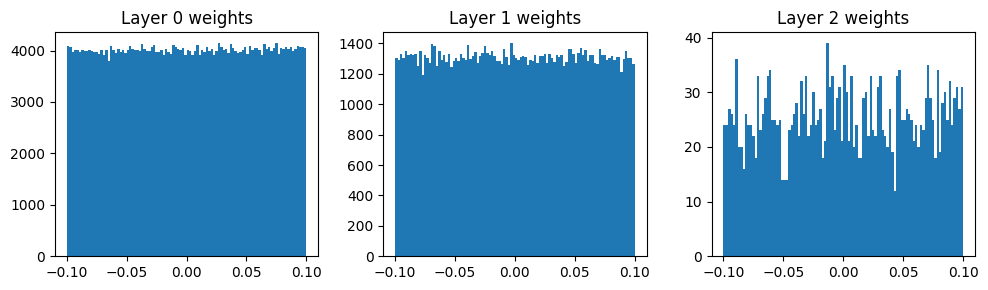

In [35]:
def print_weights(model):
    # print distribution of weights
    fig, axs = plt.subplots(1, len(model.layers), figsize=(10, 3))

    for i in range(len(model.layers)):
        axs[i].hist(model.layers[i].weight.detach().cpu().numpy().flatten(), bins=100)
        axs[i].set_title(f"Layer {i} weights")

    plt.tight_layout()
    plt.show()
    
print_weights(model)

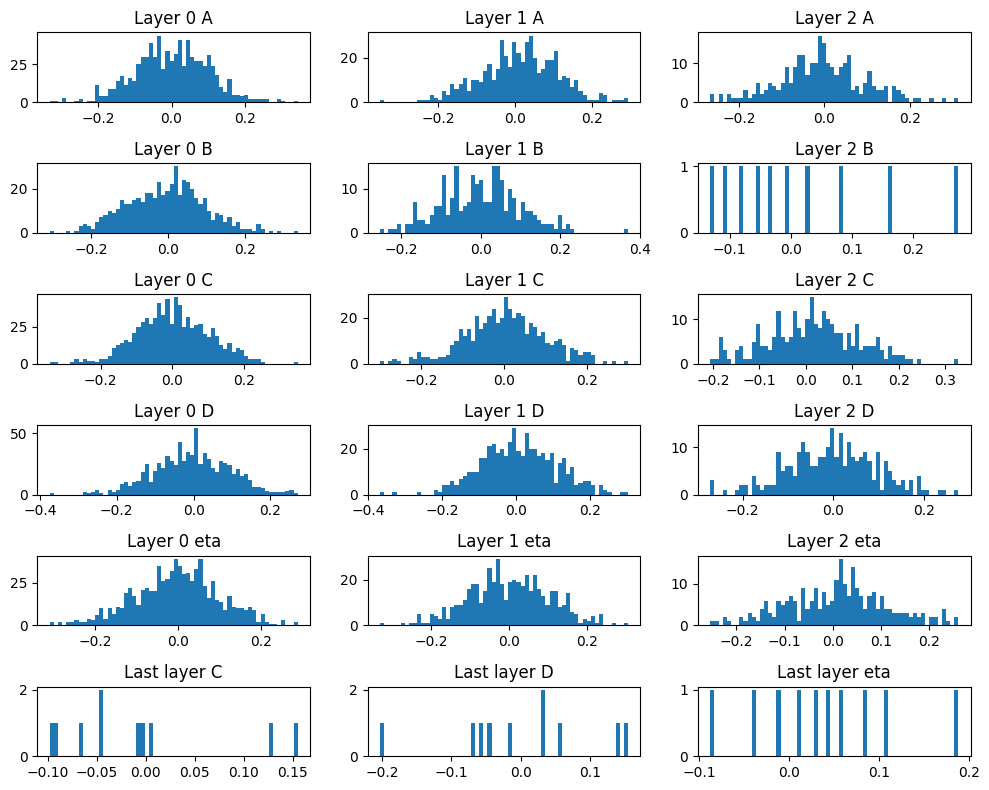

In [36]:
def print_ABCD(model):
    fig, axs = plt.subplots(6, len(model.layers), figsize=(10, 8))

    for i in range(len(model.layers)):
        axs[0, i].hist(model.layers[i].Ai.detach().cpu().numpy(), bins=60)
        axs[0, i].set_title(f"Layer {i} A")

        axs[1, i].hist(model.layers[i].Bj.detach().cpu().numpy(), bins=60)
        axs[1, i].set_title(f"Layer {i} B")

        axs[2, i].hist(model.layers[i].C.detach().cpu().numpy(), bins=60)
        axs[2, i].set_title(f"Layer {i} C")

        axs[3, i].hist(model.layers[i].D.detach().cpu().numpy(),  bins=60)
        axs[3, i].set_title(f"Layer {i} D")

        axs[4, i].hist(model.layers[i].eta.detach().cpu().numpy().flatten(), bins=60)
        axs[4, i].set_title(f"Layer {i} eta")

    axs[5, 0].hist(model.layers[len(model.layers) - 1].C_last.detach().cpu().numpy().flatten(), bins=60)
    axs[5, 0].set_title(f"Last layer C")

    axs[5, 1].hist(model.layers[len(model.layers) - 1].D_last.detach().cpu().numpy().flatten(), bins=60)
    axs[5, 1].set_title(f"Last layer D")

    axs[5, 2].hist(model.layers[len(model.layers) - 1].eta_last.detach().cpu().numpy().flatten(), bins=60)
    axs[5, 2].set_title(f"Last layer eta")

    plt.tight_layout()
    plt.show()


print_ABCD(model)

Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Test: 100%|██████████| 20/20 [00:00<00:00, 37.78batch/s, Loss=1.08] 


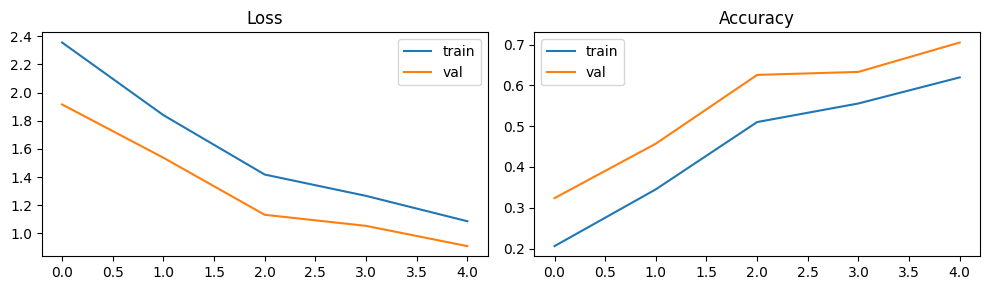

Test accuracy: 0.7076688878676471
Test loss: 0.0001981174244600184


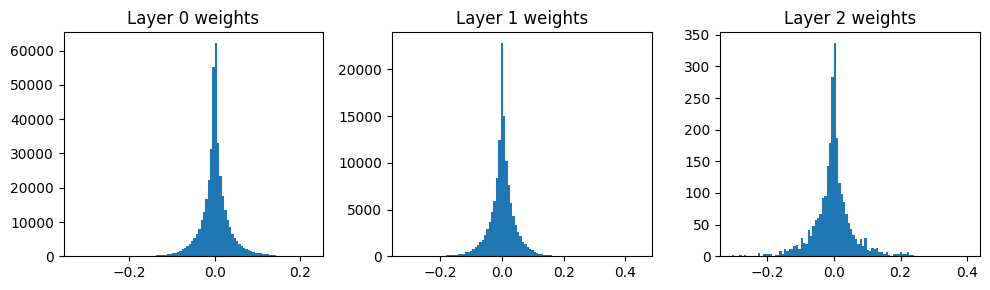

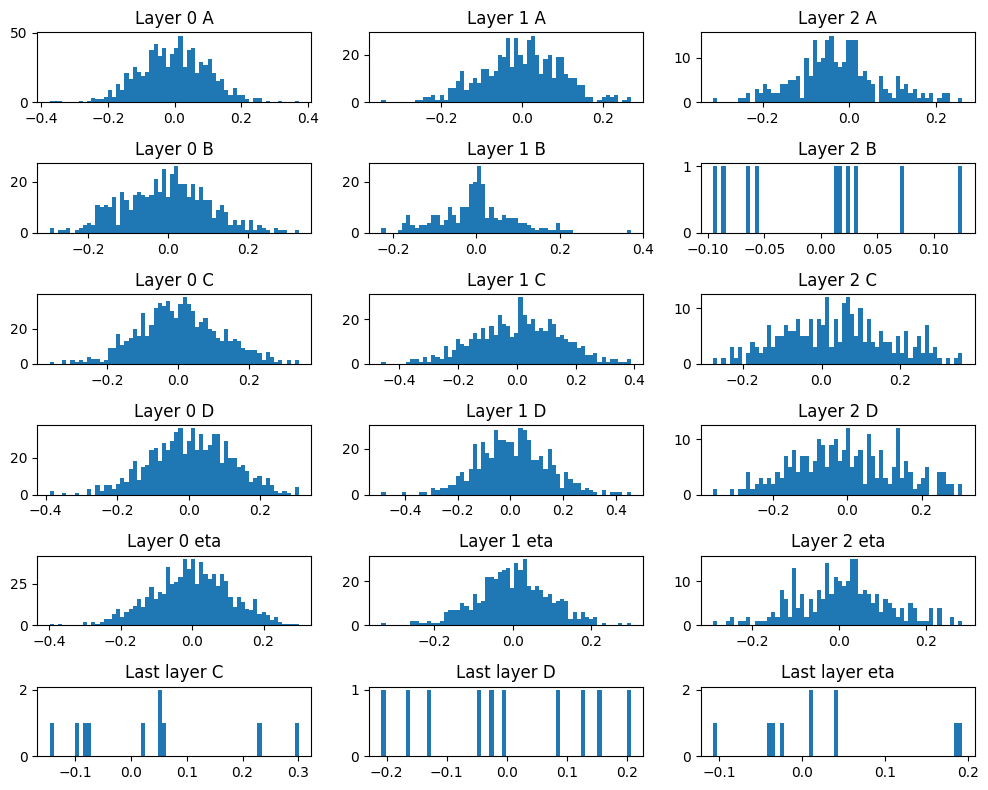

In [37]:
train = True

if train:
     # train the model with backprop
     train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = model.train_loop(
          optimizer, loss_fn, train_loader, val_loader, test_loader, epochs=5, scheduler=scheduler, log=False
     )
     # save the model   
     torch.save(model.state_dict(), "hebbian_mnist.pt")

     # plot the results
     fig, axs = plt.subplots(1, 2, figsize=(10, 3))

     # Plot loss
     axs[0].plot(train_loss, label="train")
     axs[0].plot(val_loss, label="val")
     axs[0].legend()
     axs[0].set_title("Loss")

     # Plot accuracy
     axs[1].plot(train_accuracy, label="train")
     axs[1].plot(val_accuracy, label="val")
     axs[1].legend()
     axs[1].set_title("Accuracy")

     # Adjust layout
     plt.tight_layout()
     
     # Show the plots
     plt.show()

     # print the test results
     print(f"Test accuracy: {test_accuracy}")
     print(f"Test loss: {test_loss}")

     print_weights(model)
     print_ABCD(model)

In [8]:
# laod the model
model = HebbianNetworkClassifier(model_size, device=device, init="uni", dropout=0.1)
model.load_state_dict(torch.load("hebbian_mnist.pt"))
model.reset_weights('uni')

test_loss, test_accuracy = model.test(test_loader, loss_fn)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

Test: 100%|██████████| 20/20 [00:00<00:00, 28.21batch/s, Loss=2.53]

Test accuracy: 0.07639590992647058
Test loss: 0.0004658019279732424


Test: 100%|██████████| 20/20 [00:00<00:00, 39.67batch/s, Loss=0.613]                                                                                      


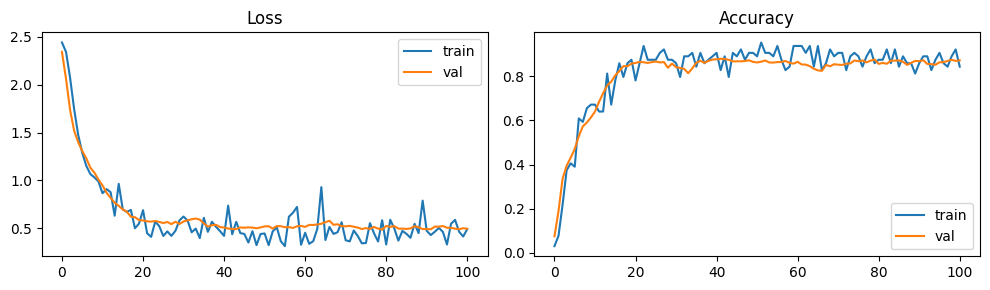

Test accuracy: 0.8810891544117647
Test loss: 0.00011270408902098151


In [9]:
train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = model.hebbian_train_loop(
    loss_fn, train_loader, val_loader, test_loader, max_iter=100
)

# plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot loss
axs[0].plot(train_loss, label="train")
axs[0].plot(val_loss, label="val")
axs[0].legend()
axs[0].set_title("Loss")

# Plot accuracy
axs[1].plot(train_accuracy, label="train")
axs[1].plot(val_accuracy, label="val")
axs[1].legend()
axs[1].set_title("Accuracy")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# print the test results
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")


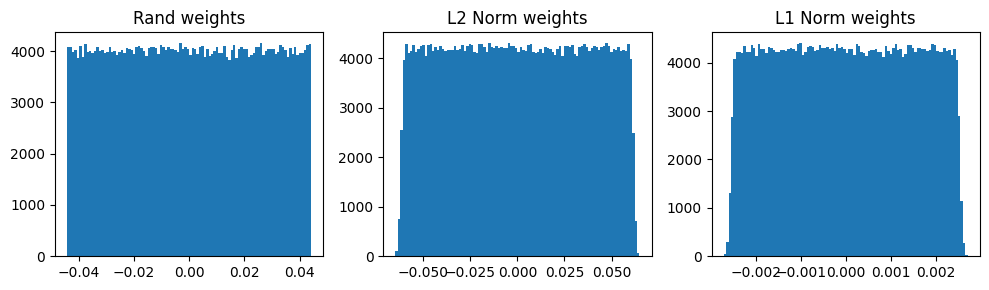

In [44]:
rand = torch.empty((784, 512))
torch.nn.init.kaiming_uniform_(rand, a=np.sqrt(5))
norml2 = torch.functional.F.normalize(rand, p=2, dim=0)
norml1 = torch.functional.F.normalize(rand, p=1, dim=0)
# print distribution of weights of norm and rand
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].hist(rand.detach().cpu().numpy().flatten(), bins=100)
axs[0].set_title(f"Rand weights")

axs[1].hist(norml2.detach().cpu().numpy().flatten(), bins=100)
axs[1].set_title(f"L2 Norm weights")

axs[2].hist(norml1.detach().cpu().numpy().flatten(), bins=100)
axs[2].set_title(f"L1 Norm weights")

plt.tight_layout()
plt.show()

In [42]:
# print the sum of the weights

print("Sum of rand weights: ", torch.sum(rand))
print("Sum of L2 norm weights: ", torch.sum(norml2))
print("Sum of L1 norm weights: ", torch.sum(norml1))

Sum of rand weights:  tensor(-4.7764)
Sum of L2 norm weights:  tensor(-8.0356)
Sum of L1 norm weights:  tensor(-0.4172)
